In [43]:
import tensorflow as tf
import numpy as np

In [44]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token

            ######################################
            ######### YOUR CODE HERE #############
            ######################################
            if token.startswith('@'):
                token = '<USR>'
            if token.lower().startswith('http://') or token.lower().startswith('https://'):
                token = '<URL>'
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

In [45]:
train_tokens, train_tags = read_data('C:\\coursera-hse-nlp-master\\coursera-hse-nlp-master\\week2\data\\train.txt')
validation_tokens, validation_tags = read_data('C:\\coursera-hse-nlp-master\\coursera-hse-nlp-master\\week2\data\\validation.txt')
test_tokens, test_tags = read_data('C:\\coursera-hse-nlp-master\\coursera-hse-nlp-master\\week2\\data\\test.txt')

In [46]:
train_tokens[1][1]
train_tags[1][1]

'I-product'

In [47]:
from collections import defaultdict

def build_dict(tokens_or_tags, special_tokens):
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    tokens = list(set([token for tweet in tokens_or_tags for token in tweet]))
    vocab = special_tokens + tokens
    
    for i,token in enumerate(vocab):
        tok2idx[token] = i
        idx2tok.append(token)
    
    return tok2idx, idx2tok

In [48]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [49]:
len(idx2token)

20505

In [50]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

In [222]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def batches_generator(batch_size, tokens, tags, shuffle=True, allow_smaller_last_batch=True):
    n_samples = len(tokens)
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1

    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        x_list = []
        y_list = []
        max_len_token = 0
        for idx in order[batch_start: batch_end]:
            x_list.append(words2idxs(tokens[idx]))
            y_list.append(tags2idxs(tags[idx]))
            max_len_token = max(max_len_token, len(tags[idx]))
            
        # Fill in the data into numpy nd-arrays filled with padding indices.
        x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
        y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['O']
        lengths = np.zeros(current_batch_size, dtype=np.int32)
        for n in range(current_batch_size):
            utt_len = len(x_list[n])
            x[n, :utt_len] = x_list[n]
            lengths[n] = utt_len
            y[n, :utt_len] = y_list[n]
        yield x, y, lengths
        
def pad_text(X, Y):
    new_X = []
    new_Y = []
    for tags in Y:
        new_Y.append(tags2idxs(tags))
    new_Y = pad_sequences(new_Y, padding='post', value=tag2idx['O'])
    max_len = len(new_Y[0])
    for seq in X:
        new_seq = []
        new_seq.extend(seq)
        rest = max_len - len(new_seq)
        if rest != 0:
            new_seq.extend(['<PAD>'] * rest)
        new_X.append(new_seq)
    return np.array(new_X), new_Y    
        
def pad_data(X, Y, max_len):
    new_X = []
    new_Y = []
    for seq, tags in zip(X, Y):
        new_X.append(words2idxs(seq))
        new_Y.append(tags2idxs(tags))
    new_X = pad_sequences(new_X, padding='post', value=token2idx['<PAD>'])
    new_Y = pad_sequences(new_Y, padding='post', value=tag2idx['O'])
    return new_X, new_Y

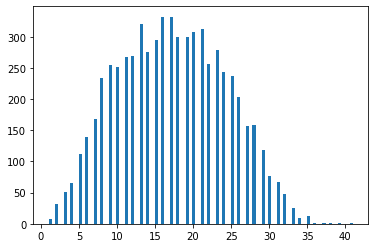

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in train_tokens + validation_tokens], bins=100)
plt.show()

In [164]:
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [167]:
def ElmoEmbedding(x):
    return elmo_model(
        inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),"sequence_len": tf.constant(batch_size*[max_len])},
        signature="tokens",
        as_dict=True)["elmo"]

In [227]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, InputLayer

max_len = 41
n_tags = len(idx2tag)
n_words = len(idx2token)
embedding_dim = 200
batch_size = 32

model = tf.keras.Sequential([
    #InputLayer(input_shape=(41,), batch_size=batch_size, dtype=tf.string),
    Embedding(input_dim=n_words, output_dim=embedding_dim, mask_zero=True),
    #Lambda(ElmoEmbedding, output_shape=(max_len, 1024)),
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(embedding_dim, max_len)),
    Bidirectional(LSTM(50)),
    Dense(max_len, activation="relu")
])

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 200)         4101000   
_________________________________________________________________
bidirectional_51 (Bidirectio (None, None, 100)         100400    
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dense_36 (Dense)             (None, 41)                4141      
Total params: 4,265,941
Trainable params: 4,265,941
Non-trainable params: 0
_________________________________________________________________


In [228]:
X_tr, y_tr = pad_data(train_tokens + validation_tokens, train_tags + validation_tags)

TypeError: pad_data() missing 1 required positional argument: 'max_len'

In [229]:
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=5, verbose=1)

Train on 6519 samples
Epoch 1/5


ValueError: could not convert string to float: 'data'

In [231]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6071375449695412080
]
